In [ ]:
!pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 33.0 MB/s eta 0:00:00



--- HASIL DIAGNOSA ---
Input Pasien:
1. Suhu      : 38.5 °C
2. Trombosit : 120 (10^9/L)
3. Leukosit  : 3.8 (10^9/L)
------------------------------
Skor Risiko DBD (Defuzzified): 80.00

Derajat Keanggotaan Output:
- Rendah: 0.0000
- Sedang: 0.0000
- Tinggi: 1.0000


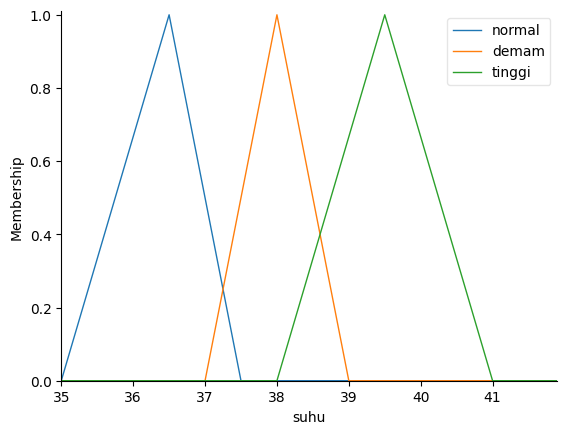

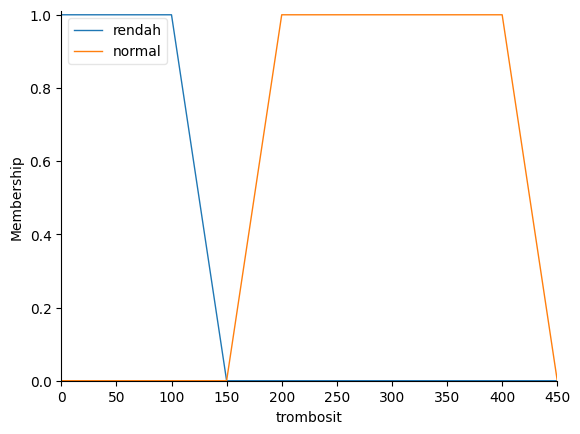

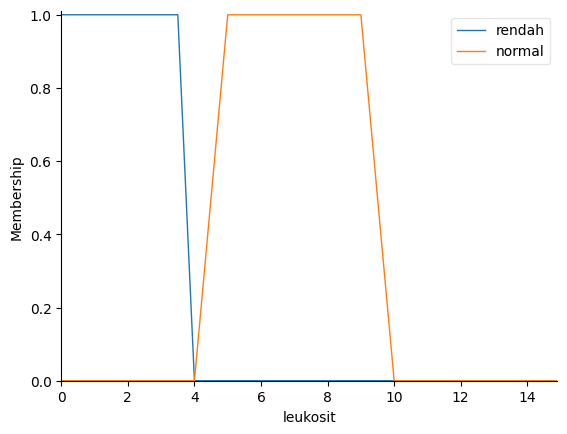

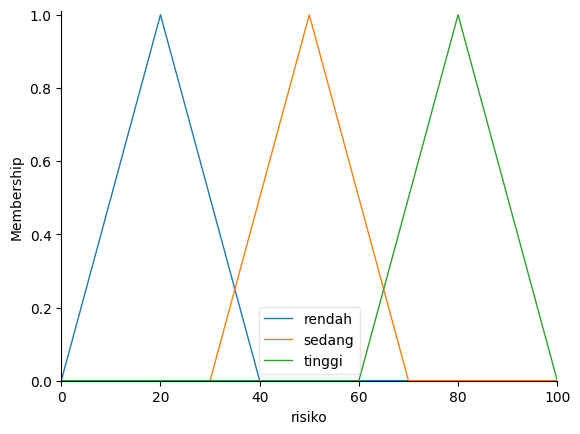

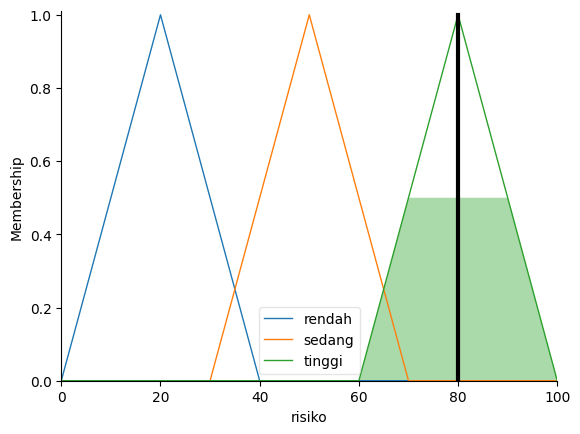

In [ ]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

# ==========================================
# 1. DEFINISI VARIABEL (FUZZY VARIABLES)
# ==========================================
# Referensi Range dari Soal [cite: 8, 17, 21, 28]

# Antecedents (Input)
# Suhu: Range 36-41 (estimasi universe)
suhu = ctrl.Antecedent(np.arange(35, 42, 0.1), 'suhu')

# Trombosit: Range 0 - 450 (10^9/L)
trombosit = ctrl.Antecedent(np.arange(0, 451, 1), 'trombosit')

# Leukosit: Range 0 - 15 (10^9/L)
leukosit = ctrl.Antecedent(np.arange(0, 15, 0.1), 'leukosit')

# Consequent (Output)
# Risiko DBD: Range 0-100 [cite: 31]
risiko = ctrl.Consequent(np.arange(0, 101, 1), 'risiko')

# ==========================================
# 2. FUNGSI KEANGGOTAAN (MEMBERSHIP FUNCTIONS)
# ==========================================
# Menggunakan range yang tertera pada soal [cite: 13-16, 23-26, 32-38]

# --- SUHU ---
# Normal: 36-37.5
suhu['normal'] = fuzz.trimf(suhu.universe, [35, 36.5, 37.5])
# Demam: 37-39
suhu['demam'] = fuzz.trimf(suhu.universe, [37, 38, 39])
# Tinggi: 38-41
suhu['tinggi'] = fuzz.trimf(suhu.universe, [38, 39.5, 41])

# --- TROMBOSIT ---
# Rendah: < 150
trombosit['rendah'] = fuzz.trapmf(trombosit.universe, [0, 0, 100, 150])
# Normal: 150-400
trombosit['normal'] = fuzz.trapmf(trombosit.universe, [150, 200, 400, 450])

# --- LEUKOSIT ---
# Rendah: < 4
leukosit['rendah'] = fuzz.trapmf(leukosit.universe, [0, 0, 3.5, 4])
# Normal: 4-10
leukosit['normal'] = fuzz.trapmf(leukosit.universe, [4, 5, 9, 10])

# --- RISIKO (OUTPUT) ---
# Rendah: 0-40
risiko['rendah'] = fuzz.trimf(risiko.universe, [0, 20, 40])
# Sedang: 30-70
risiko['sedang'] = fuzz.trimf(risiko.universe, [30, 50, 70])
# Tinggi: 60-100
risiko['tinggi'] = fuzz.trimf(risiko.universe, [60, 80, 100])

# Visualisasi Membership Function (Opsional)
suhu.view()
trombosit.view()
leukosit.view()
risiko.view()

# ==========================================
# 3. ATURAN FUZZY (FUZZY RULES)
# ==========================================
# Berdasarkan Soal Bagian B Poin 3 [cite: 37-47]

# Rule 1: Jika Suhu tinggi AND Trombosit rendah AND Leukosit rendah maka Risiko = Tinggi
rule1 = ctrl.Rule(suhu['tinggi'] & trombosit['rendah'] & leukosit['rendah'], risiko['tinggi'])

# Rule 2: Jika Suhu demam AND Trombosit rendah maka Risiko = Tinggi
rule2 = ctrl.Rule(suhu['demam'] & trombosit['rendah'], risiko['tinggi'])

# Rule 3: Jika Suhu demam AND Trombosit normal maka Risiko = Sedang
rule3 = ctrl.Rule(suhu['demam'] & trombosit['normal'], risiko['sedang'])

# Rule 4: Jika Suhu normal AND Trombosit normal AND Leukosit normal maka Risiko = Rendah
rule4 = ctrl.Rule(suhu['normal'] & trombosit['normal'] & leukosit['normal'], risiko['rendah'])

# Rule 5: Jika Suhu tinggi AND Leukosit normal maka Risiko = Sedang
rule5 = ctrl.Rule(suhu['tinggi'] & leukosit['normal'], risiko['sedang'])

# Membuat Control System
risiko_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5])
diagnosa_dbd = ctrl.ControlSystemSimulation(risiko_ctrl)

# ==========================================
# 4. SIMULASI KASUS PASIEN
# ==========================================
# Data Pasien dari Soal [cite: 55-57]:
# Suhu: 38.5
# Trombosit: 120
# Leukosit: 3.8

print("\n--- HASIL DIAGNOSA ---")
inputs = {'suhu': 38.5, 'trombosit': 120, 'leukosit': 3.8}

# Memasukkan input ke sistem
diagnosa_dbd.input['suhu'] = inputs['suhu']
diagnosa_dbd.input['trombosit'] = inputs['trombosit']
diagnosa_dbd.input['leukosit'] = inputs['leukosit']

# Melakukan komputasi (Defuzzifikasi)
diagnosa_dbd.compute()

# Hasil Output Defuzzifikasi (Crisp Output)
hasil_skor = diagnosa_dbd.output['risiko']
print(f"Input Pasien:")
print(f"1. Suhu      : {inputs['suhu']} °C")
print(f"2. Trombosit : {inputs['trombosit']} (10^9/L)")
print(f"3. Leukosit  : {inputs['leukosit']} (10^9/L)")
print("-" * 30)
print(f"Skor Risiko DBD (Defuzzified): {hasil_skor:.2f}")

# Menentukan Kategori Linguistik dari Hasil Crisp
# Kita cek derajat keanggotaan output terhadap himpunan risiko
print("\nDerajat Keanggotaan Output:")
for label in ['rendah', 'sedang', 'tinggi']:
    derajat = fuzz.interp_membership(risiko.universe, risiko[label].mf, hasil_skor)
    print(f"- {label.capitalize()}: {derajat:.4f}")

# Visualisasi Hasil pada Grafik Output
risiko.view(sim=diagnosa_dbd)
plt.show()

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. DEFINISI FUNGSI KEANGGOTAAN (MF)
# ==========================================
# Fungsi segitiga standar (Trimf) sesuai struktur model [cite: 69, 71, 74, 75]
def trimf(x, abc):
    """
    Fungsi keanggotaan segitiga
    x: input value
    abc: list/array [a, b, c]
    """
    a, b, c = abc
    # Mencegah pembagian dengan nol
    if a == b: return 1.0 if x == a else 0.0 # Handle vertical line
    if b == c: return 1.0 if x == b else 0.0

    # Logic Trimf
    if x <= a or x >= c:
        return 0.0
    elif a < x <= b:
        return (x - a) / (b - a)
    elif b < x < c:
        return (c - x) / (c - b)
    return 0.0

# ==========================================
# 2. PARAMETER MODEL (DARI SOAL)
# ==========================================

# Parameter Premis (Membership Functions)
# Input 1: Soil Moisture (X1)
mf_x1_low  = [0, 30, 60]    # [cite: 69]
mf_x1_high = [40, 70, 100]  # [cite: 71]

# Input 2: Avg Temp (X2)
mf_x2_low  = [15, 20, 25]   # [cite: 74]
mf_x2_high = [22, 28, 35]   # [cite: 75]

# Parameter Konsekuen (Linear: y = px1 + qx2 + r)
# Dikelompokkan per rule [cite: 83-84]
params = {
    'R1': {'p': 0.0692, 'q': 0.0461, 'r': 0.00231},
    'R2': {'p': 0.0698, 'q': 0.0390, 'r': 0.00139},
    'R3': {'p': 0.0585, 'q': 0.0183, 'r': 0.00084},
    'R4': {'p': 0.0505, 'q': 0.0318, 'r': 0.00115}
}

# ==========================================
# 3. FUNGSI UTAMA ANFIS (FORWARD PASS)
# ==========================================
def hitung_anfis(x1_val, x2_val):
    print(f"--- PERHITUNGAN ANFIS (x1={x1_val}, x2={x2_val}) ---")

    # --- LAYER 1: FUZZIFIKASI ---
    # Hitung derajat keanggotaan (mu) untuk setiap input
    mu_x1_low  = trimf(x1_val, mf_x1_low)
    mu_x1_high = trimf(x1_val, mf_x1_high)

    mu_x2_low  = trimf(x2_val, mf_x2_low)
    mu_x2_high = trimf(x2_val, mf_x2_high)

    print("\n1. Derajat Keanggotaan (Layer 1):")
    print(f"   Mu X1 Low  : {mu_x1_low:.4f} | Mu X1 High : {mu_x1_high:.4f}")
    print(f"   Mu X2 Low  : {mu_x2_low:.4f} | Mu X2 High : {mu_x2_high:.4f}")

    # --- LAYER 2: FIRING STRENGTH (WEIGHTS) ---
    # Menggunakan operator AND (Min) atau Product.
    # Standar Sugeno sering menggunakan Product, tapi di sini kita gunakan Min (umum di Fuzzy dasar).
    # Rule 1: IF X1 Low AND X2 Low [cite: 79]
    w1 = min(mu_x1_low, mu_x2_low)

    # Rule 2: IF X1 Low AND X2 High (Diasumsikan dari pola, teks soal terpotong) [cite: 80]
    w2 = min(mu_x1_low, mu_x2_high)

    # Rule 3: IF X1 High AND X2 Low [cite: 82]
    w3 = min(mu_x1_high, mu_x2_low)

    # Rule 4: IF X1 High AND X2 High [cite: 82]
    w4 = min(mu_x1_high, mu_x2_high)

    total_w = w1 + w2 + w3 + w4
    print("\n2. Firing Strength (Layer 2 - Weights):")
    print(f"   w1 (L-L): {w1:.4f}")
    print(f"   w2 (L-H): {w2:.4f}")
    print(f"   w3 (H-L): {w3:.4f}")
    print(f"   w4 (H-H): {w4:.4f}")
    print(f"   Total Weight: {total_w:.4f}")

    # --- LAYER 3 & 4: KONSEKUEN & DEFUZZIFIKASI ---
    # Rumus Sugeno Orde-1: y = p*x1 + q*x2 + r [cite: 77]
    # Output Akhir = Sigma(wi * yi) / Sigma(wi)

    y_final_numerator = 0
    print("\n3. Perhitungan Konsekuen (Layer 3 & 4):")

    rules_config = [
        (w1, params['R1'], "R1"),
        (w2, params['R2'], "R2"),
        (w3, params['R3'], "R3"),
        (w4, params['R4'], "R4")
    ]

    for w, p_vals, name in rules_config:
        # Hitung y untuk rule tersebut
        y_val = (p_vals['p'] * x1_val) + (p_vals['q'] * x2_val) + p_vals['r']

        # Hitung kontribusi (w * y)
        w_y = w * y_val
        y_final_numerator += w_y

        print(f"   {name}: y = {p_vals['p']}*{x1_val} + {p_vals['q']}*{x2_val} + {p_vals['r']} = {y_val:.4f}")
        print(f"       Kontribusi (w * y) = {w:.4f} * {y_val:.4f} = {w_y:.4f}")

    # --- LAYER 5: OUTPUT AKHIR ---
    if total_w == 0:
        prediction = 0 # Hindari pembagian 0 jika tidak ada rule yang fire
    else:
        prediction = y_final_numerator / total_w

    return prediction

# ==========================================
# 4. EKSEKUSI KASUS
# ==========================================
# Input dari soal: x1 = 60, x2 = 26 [cite: 85]
input_x1 = 60
input_x2 = 26

hasil_prediksi = hitung_anfis(input_x1, input_x2)

print("\n" + "="*40)
print(f"PREDIKSI PRODUKSI JAGUNG: {hasil_prediksi:.5f} ton/ha")
print("="*40)

--- PERHITUNGAN ANFIS (x1=60, x2=26) ---

1. Derajat Keanggotaan (Layer 1):
   Mu X1 Low  : 0.0000 | Mu X1 High : 0.6667
   Mu X2 Low  : 0.0000 | Mu X2 High : 0.6667

2. Firing Strength (Layer 2 - Weights):
   w1 (L-L): 0.0000
   w2 (L-H): 0.0000
   w3 (H-L): 0.0000
   w4 (H-H): 0.6667
   Total Weight: 0.6667

3. Perhitungan Konsekuen (Layer 3 & 4):
   R1: y = 0.0692*60 + 0.0461*26 + 0.00231 = 5.3529
       Kontribusi (w * y) = 0.0000 * 5.3529 = 0.0000
   R2: y = 0.0698*60 + 0.039*26 + 0.00139 = 5.2034
       Kontribusi (w * y) = 0.0000 * 5.2034 = 0.0000
   R3: y = 0.0585*60 + 0.0183*26 + 0.00084 = 3.9866
       Kontribusi (w * y) = 0.0000 * 3.9866 = 0.0000
   R4: y = 0.0505*60 + 0.0318*26 + 0.00115 = 3.8580
       Kontribusi (w * y) = 0.6667 * 3.8580 = 2.5720

PREDIKSI PRODUKSI JAGUNG: 3.85795 ton/ha
